# 1D cardiovascular network model

In this notebook, we will construct a frequency-based computational model of the human cardiovascular tree and use it to inspect the pressure and flow rate in different arterial segments.

In [1]:
using Cardio1D

[ Info: Precompiling Cardio1D [60727eac-f7d1-4dc9-8583-3246d531585b]


In [2]:
using Plots
using JLD2

## Loading the tree data
We will load the tree data from a file. The data in this file was obtained from a variety of sources, primarily from

- Westerhof et al. 1969, "Analog studies of the human systemic arterial tree," J. Biomech., 2, 121-143.

and

- Avolio A. P. 1980, "Multi-branched model of the human arterial system", Med. Biol. Eng. Comput, 18, 709-718.

It also contains some modifications made by

- Stergiopulos et al. 1992, "Computer simulation of arterial flow with application to arterial and aortic stenoses", J. Biomech., 25(12), 1477-1488.

and

- Wang and Parker 2004, "Wave propagation in a model of the arterial circulation," J. Biomech., 37, 457-470.

In [3]:
data = load("cvtree.jld2")

Cardiovascular tree data with 128 segments


In [4]:
cv = data["cvtree"]

Cardiovascular tree data with 128 segments


Every arterial segment has a unique identifier (an integer). The tree allows us to determine parent and daughter vessels for each segment.

In [5]:
id = 2

2

Segment name

In [6]:
name(id,cv)

"Aortic arch"

Parent ID

In [7]:
parent_id(id,cv)

1

Name of the parent

In [8]:
parent_name(id,cv)

"Ascending aorta"

Daughter IDs

In [9]:
daughter_ids(id,cv)

4-element Vector{Int64}:
 3
 4
 5
 6

Daughter names

In [10]:
daughter_names(id,cv)

4-element Vector{String}:
 "Leftsubclavian artery"
 "Common carotid(L)"
 "Aortic arch"
 "Brachiocephalic artery"

If a segment has no daughters, then it is a terminal branch:

In [11]:
daughter_ids(122,cv)

Int64[]

The tree also contains the basic physical properties of the vessels and of blood. All units are in SI.

In [12]:
cv.radii[id]

0.011200000000000002

In [13]:
cv.lengths[id]

0.02

In [14]:
cv.blood_viscosity

0.004

## Loading a cardiac waveform
Here, we load a waveform containing the time (in sec), the pressure (in mmHg) and the flow rate (in mL/sec).

In [15]:
data = load("cvdata.jld2")

Dict{String, Any} with 3 entries:
  "P_mmHg"     => [68.3471, 67.5055, 66.4575, 65.4623, 65.2686, 65.1091, 65.542…
  "t_sec"      => [0.0, 0.00323736, 0.00647472, 0.00971208, 0.0129494, 0.016186…
  "Q_mlpersec" => [28.6651, 31.3566, 34.0482, 38.3394, 44.3634, 51.5952, 59.470…

In [16]:
t_sec_loaded = data["t_sec"]
P0_mmHg = data["P_mmHg"]
Q0_mlpersec = data["Q_mlpersec"];

## Build the tree impedances
Now we build the machinery of the cardiovascular network (using `build_network_impedances`): the inlet and outlet impedances of every segment (`Z0` and `Zt`) and the transmission coefficients (`ptrans`) through each segment.

First, however, we have to construst the list of frequencies at which we will compute these. The time array that we loaded in the previous step is based on a particular heart rate, and we could use that array to set the basic frequency of our array. However, we can also rescale time however we wish to make the waveform correspond to a different heart rate. Here, we set the heart rate at 75 beats/minute. (If we had omitted this argument, it would use the heart rate in the original waveform.)

In [17]:
freq, t_sec = get_frequencies(t_sec_loaded;heartrate_bpm=75);

In [18]:
Z0, Zt, ptrans = build_network_impedances(freq,cv);

## Look at signals

Let's look at the pressure and flow rate in a particular segment. Here, we will use `id=1`, which is the ascending aorta (the segment that is connected to the heart).

It is important to note that we using the flow rate provided in the loaded waveform file to compute every other signal in the network, *including the pressure at the inlet of the aorta*. In other words, we are *not* using the loaded pressure waveform, but rather, we are computing it from $Q$, using the impedance at the inlet of the aorta. This will likely be different from the loaded waveform, since those loaded waveforms corresponded to a different individual with different cardiovascular system.

In [19]:
id = 1
Pk_mmHg, Qk_mlpersec = get_signals_in_segment(id,Q0_mlpersec,Z0,ptrans,cv);

Let's plot the signals in the ascending aorta.

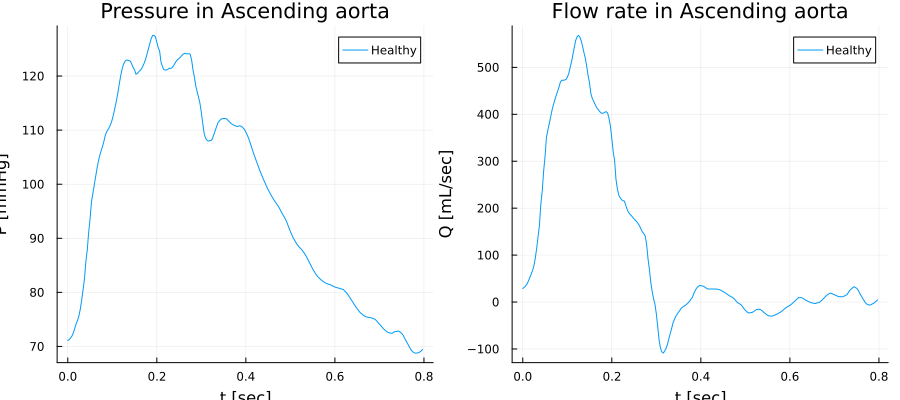

In [20]:
plot(
    plot(t_sec,Pk_mmHg,ylabel="P [mmHg]",xlabel="t [sec]",title="Pressure in "*name(id,cv),label="Healthy"),
    plot(t_sec,Qk_mlpersec,ylabel="Q [mL/sec]",xlabel="t [sec]",title="Flow rate in "*name(id,cv),label="Healthy"),
    size = (900,400)
    )

Now let's choose a particular segment, down in the lower left leg, and show how the waveforms evolve as it proceeds there from the heart.

In [21]:
id = 125
name(id,cv)

"Left Anteriortibial artery"

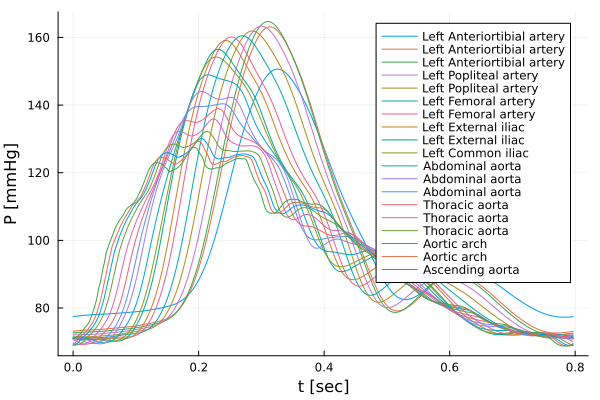

In [22]:
p_id = cv.parents[id]
Pk_mmHg, Qk_mlpersec = get_signals_in_segment(id,Q0_mlpersec,Z0,ptrans,cv);
ps = plot(t_sec,Pk_mmHg,label=cv.names[id],ylabel="P [mmHg]",xlabel="t [sec]")
while p_id > 0
    Pk_mmHg, Qk_mlpersec = get_signals_in_segment(p_id,Q0_mlpersec,Z0,ptrans,cv);
    plot!(ps,t_sec,Pk_mmHg,label=cv.names[p_id])
    p_id = parent_id(p_id,cv)
end
display(ps)

The pressure signal exhibits a time delay -- the time to travel from heart to lower leg. It also smooths out.

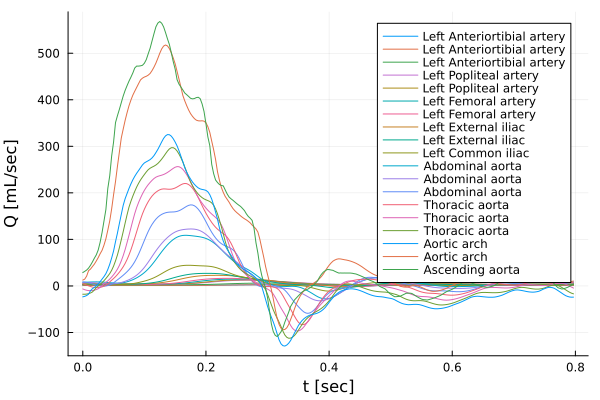

In [23]:
p_id = cv.parents[id]
Pk_mmHg, Qk_mlpersec = get_signals_in_segment(id,Q0_mlpersec,Z0,ptrans,cv);
ps = plot(t_sec,Qk_mlpersec,label=cv.names[id],ylabel="Q [mL/sec]",xlabel="t [sec]")
while p_id > 0
    Pk_mmHg, Qk_mlpersec = get_signals_in_segment(p_id,Q0_mlpersec,Z0,ptrans,cv);
    plot!(ps,t_sec,Qk_mlpersec,label=cv.names[p_id])
    p_id = parent_id(p_id,cv)
end
display(ps)

The flow rate drops every time there is a bifurcation. However, it also spreads out, so that there is more continuous flow during the full heart beat.

## Simulate disease
Here, we will modify a portion of the cardiovascular network to simulate disease and inspect the effect on the flow.

First, we will set the heart rate.

In [25]:
freq, t_sec = get_frequencies(t_sec_loaded;heartrate_bpm=75);

Then, we will choose a particular segment to modify. In this example, the left common carotid, which goes to the head.

In [26]:
modid = 4
name(modid,cv)

"Common carotid(L)"

Now we will make a copy of the network (so we can compare). In this example, we will decrease the radius of the artery, but keep its elastic modulus the same.

In [27]:
cv_mod = deepcopy(cv)
cv_mod.radii[modid] = cv.radii[modid]*0.5
cv_mod.moduli[modid] = cv.moduli[modid]*1.0

400000.0

Let's inspect the results in a particular segment. Here, we will just choose the same segment we modified. But we can also look at how the modification has affected flow in other segments.

In [28]:
inspect_id = 4
name(inspect_id,cv)

"Common carotid(L)"

Compute the signals in the "healthy" patient

In [29]:
Z0, Zt, ptrans = build_network_impedances(freq,cv)
Pk_mmHg, Qk_mlpersec = get_signals_in_segment(inspect_id,Q0_mlpersec,Z0,ptrans,cv);

and in the "diseased" patient

In [30]:
Z0_mod, Zt_mod, ptrans_mod = build_network_impedances(freq,cv_mod)
Pk_mmHg_mod, Qk_mlpersec_mod = get_signals_in_segment(inspect_id,Q0_mlpersec,Z0_mod,ptrans_mod,cv_mod);

Now construct plots that compare them:

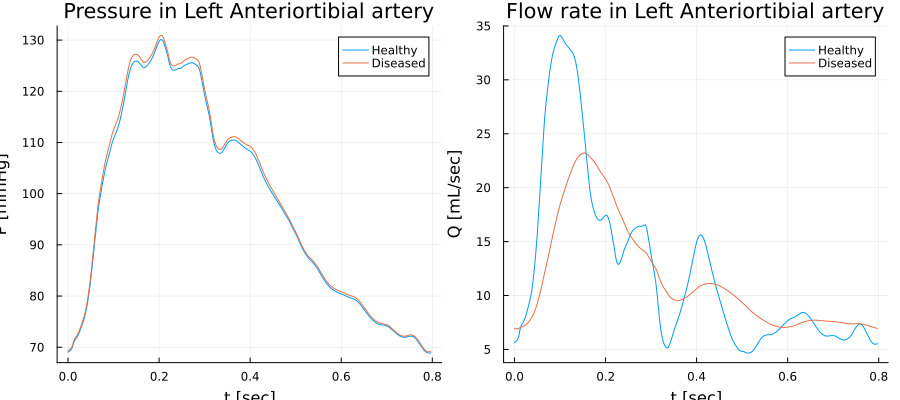

In [31]:
psp = plot(t_sec,Pk_mmHg,ylabel="P [mmHg]",xlabel="t [sec]",title="Pressure in "*name(id,cv),label="Healthy")
plot!(psp,t_sec,Pk_mmHg_mod,label="Diseased")
psQ = plot(t_sec,Qk_mlpersec,ylabel="Q [mL/sec]",xlabel="t [sec]",title="Flow rate in "*name(id,cv),label="Healthy")
plot!(psQ,t_sec,Qk_mlpersec_mod,label="Diseased")
plot(psp,psQ, size = (900,400))